#  Machine Learning and Causal Inference - Problem Set 2

By Mathieu Breier, Joaquin Ossa

Date: 19 February 2024

------------------------

### Objective: Calculating the ATE of the RHC dataset, implementing the Double ML technique with cross-fitting

+ Treatment (D): swang1
+ Outcome (Y): death
+ Confounders (X): confounder.yml


#### 1. Train ML model Y~X and calculate residuals using cross-fitting
- Execute cross-validation (train-test split) over a subset of hyperparameters, and choose the one with lower error. You can use functions that simplify the search of optimal parameters, such as caret in (R ) or GridSearchCV in scikit learn


#### 2. Train ML model D~X and calculate residuals using cross-fitting
- Execute cross-validation (train-test split) over a subset of hyperparameters, and choose the one with lower error. You can use functions that simplify the search of optimal parameters, such as caret in (R ) or GridSearchCV in scikit learn


#### 3. Run linear regression Yresiduals~ Dresiduals

Finally, check that the results are similar than the ones DoubleML would give (RHC data ATE estimation with DoubleML (Python).ipynb)

|        | $coef$         | $std\ err$    | $t$           | $P>\|t\|$       | $2.5%$        | $97.5%$       |
|:------:|:------------:|:-----------:|:-----------:|:-----------:|:-----------:|:-----------:|
| swang1 | 0.039061     | 0.013351    | 2.925709    | 0.003437    | 0.012894    | 0.065229    |

----------------



In [224]:
import pandas as pd
import yaml
import numpy as np
from numpy.random import seed
import matplotlib.pyplot as plt
import seaborn as sns

import doubleml as dml

from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV, LogisticRegressionCV                # Lasso
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor    # Random Forest
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor        # Tree
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error as rmse
from xgboost import XGBClassifier, XGBRegressor
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

import random

#warnings
import warnings
warnings.filterwarnings('ignore')

seed(123)

In [225]:
rhc = pd.read_csv("rhc.csv")
with open("confounders.yml", "r") as f:
    confounders = yaml.safe_load(f)

rhc["swang1"] = (rhc["swang1"] == "RHC").astype(int)
rhc["death"] = (rhc["death"] == "Yes").astype(int)
rhc.groupby("swang1")["death"].mean()

rhc_numerical = pd.get_dummies(rhc[['swang1', 'death'] + confounders], dtype=float, drop_first=True)

In [226]:
confounders = [
    "age", "sex", "race", "edu", "income", "ninsclas", "cat1", "das2d3pc", "dnr1", "ca",
    "surv2md1", "aps1", "scoma1", "wtkilo1", "temp1", "meanbp1", "resp1", "hrt1", "pafi1",
    "paco21", "ph1", "wblc1", "hema1", "sod1", "pot1", "crea1", "bili1", "alb1", "resp",
    "card", "neuro", "gastr", "renal", "meta", "hema", "seps", "trauma", "ortho", "cardiohx",
    "chfhx", "dementhx", "psychhx", "chrpulhx", "renalhx", "liverhx", "gibledhx", "malighx",
    "immunhx", "transhx", "amihx"
]


In [227]:
rhc.head(5)

,Unnamed: 0,cat1,cat2,ca,sadmdte,dschdte,dthdte,lstctdte,death,cardiohx,...,meta,hema,seps,trauma,ortho,adld3p,urin1,race,income,ptid
0,1,COPD,NaN,Yes,11142,11151.0,NaN,11382,0,0,...,No,No,No,No,No,0.0,NaN,white,Under $11k,5
1,2,MOSF w/Sepsis,NaN,No,11799,11844.0,11844.0,11844,1,1,...,No,No,Yes,No,No,NaN,1437.0,white,Under $11k,7
2,3,MOSF w/Malignancy,MOSF w/Sepsis,Yes,12083,12143.0,NaN,12400,0,0,...,No,No,No,No,No,NaN,599.0,white,$25-$50k,9
3,4,ARF,NaN,No,11146,11183.0,11183.0,11182,1,0,...,No,No,No,No,No,NaN,NaN,white,$11-$25k,10
4,5,MOSF w/Sepsis,NaN,No,12035,12037.0,12037.0,12036,1,0,...,No,No,No,No,No,NaN,64.0,white,Under $11k,11


In [228]:
rhc.shape

(5735, 63)

### Preprocessing

In [229]:
# count of rows with na
rhc.isna().sum()

Unnamed: 0       0
cat1             0
cat2          4535
ca               0
sadmdte          0
              ... 
adld3p        4296
urin1         3028
race             0
income           0
ptid             0
Length: 63, dtype: int64

In [230]:
# Remove missing values: remove columns (features) with missing values
rhc = rhc.dropna(axis=1)

In [231]:
def binary(column):
    return column.map({'Yes': 1, 'No': 0})

binary_columns = ['ca','dnr1','dth30','resp', 'card', 'neuro', 'gastr','renal', 'meta', 'seps', 'trauma','ortho','hema']

for col in binary_columns:
    rhc[col] = binary(rhc[col])

In [232]:
# remove missing values: remove rows (patients) with missing values
rhc = rhc.dropna(axis=0)

In [233]:
# hot one encoding for categorical variables: cat1, race, income, sex, swang1, ninsclas
categorical_columns = ['cat1', 'race', 'income', 'sex', 'swang1', 'ninsclas']
rhc = pd.get_dummies(rhc, columns=categorical_columns, drop_first=False)


In [234]:
def convert_booleans_to_integers(df):
    for column_name in df.columns:
        if df[column_name].dtype == 'bool':
            df[column_name].replace({True: 1, False: 0}, inplace=True)
    return df

rhc = convert_booleans_to_integers(rhc)

In [235]:
# shape
rhc.shape

(5351, 76)

In [236]:
#head 5
rhc.head(5)

,Unnamed: 0,ca,sadmdte,lstctdte,death,cardiohx,chfhx,dementhx,psychhx,chrpulhx,...,sex_Female,sex_Male,swang1_0,swang1_1,ninsclas_Medicaid,ninsclas_Medicare,ninsclas_Medicare & Medicaid,ninsclas_No insurance,ninsclas_Private,ninsclas_Private & Medicare
0,1,1.0,11142,11382,0,0,0,0,0,1,...,0,1,1,0,0,1,0,0,0,0
1,2,0.0,11799,11844,1,1,1,0,0,0,...,1,0,0,1,0,0,0,0,0,1
2,3,1.0,12083,12400,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,1,0
3,4,0.0,11146,11182,1,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,1
4,5,0.0,12035,12036,1,0,0,0,0,0,...,0,1,0,1,0,1,0,0,0,0


------------------

### 1. Train ML model Y~X and calculate residuals using cross-fitting
- Execute cross-validation (train-test split) over a subset of hyperparameters, and choose the one with lower error. You can use functions that simplify the search of optimal parameters, such as caret in (R ) or GridSearchCV in scikit learn


In [237]:
X = rhc.drop('death', axis=1)
y = rhc['death']

In [238]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [239]:
class OutlierClipper(BaseEstimator, TransformerMixin):
    def __init__(self, lower_percentile=25, upper_percentile=75, factor=1.5):
        self.lower_percentile = lower_percentile
        self.upper_percentile = upper_percentile
        self.factor = factor
    
    def fit(self, X, y=None):
        Q1 = np.percentile(X, self.lower_percentile, axis=0)
        Q3 = np.percentile(X, self.upper_percentile, axis=0)
        IQR = Q3 - Q1
        self.lower_bound = Q1 - self.factor * IQR
        self.upper_bound = Q3 + self.factor * IQR
        return self
    
    def transform(self, X, y=None):
        X_clipped = np.clip(X, self.lower_bound, self.upper_bound)
        return X_clipped

In [240]:
model = RandomForestClassifier()

In [241]:
# Define your parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    # Add other parameters here as needed
}

In [242]:
# Use GridSearchCV to find the best model
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', verbose = 3)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[CV 1/5] END ..max_depth=None, n_estimators=100;, score=0.783 total time=   0.4s
[CV 2/5] END ..max_depth=None, n_estimators=100;, score=0.807 total time=   0.4s
[CV 3/5] END ..max_depth=None, n_estimators=100;, score=0.771 total time=   0.4s
[CV 4/5] END ..max_depth=None, n_estimators=100;, score=0.801 total time=   0.4s
[CV 5/5] END ..max_depth=None, n_estimators=100;, score=0.796 total time=   0.4s
[CV 1/5] END ..max_depth=None, n_estimators=200;, score=0.778 total time=   0.8s
[CV 2/5] END ..max_depth=None, n_estimators=200;, score=0.801 total time=   0.8s
[CV 3/5] END ..max_depth=None, n_estimators=200;, score=0.772 total time=   0.8s
[CV 4/5] END ..max_depth=None, n_estimators=200;, score=0.803 total time=   0.8s
[CV 5/5] END ..max_depth=None, n_estimators=200;, score=0.779 total time=   0.8s
[CV 1/5] END .....max_depth=5, n_estimators=100;, score=0.766 total time=   0.2s
[CV 2/5] END .....max_depth=5, n_estimators=100;, score=0.787 total time=   0.2s
[CV 3/5] END .....max_depth=

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 5, 10],
                         'n_estimators': [100, 200]},
             scoring='accuracy', verbose=3)

In [243]:
# Best model parameters
print("Best parameters:", grid_search.best_params_)


Best parameters: {'max_depth': 10, 'n_estimators': 200}


In [244]:
y_pred = grid_search.predict(X_test)

In [245]:
# Calculate residuals
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7861811391223156


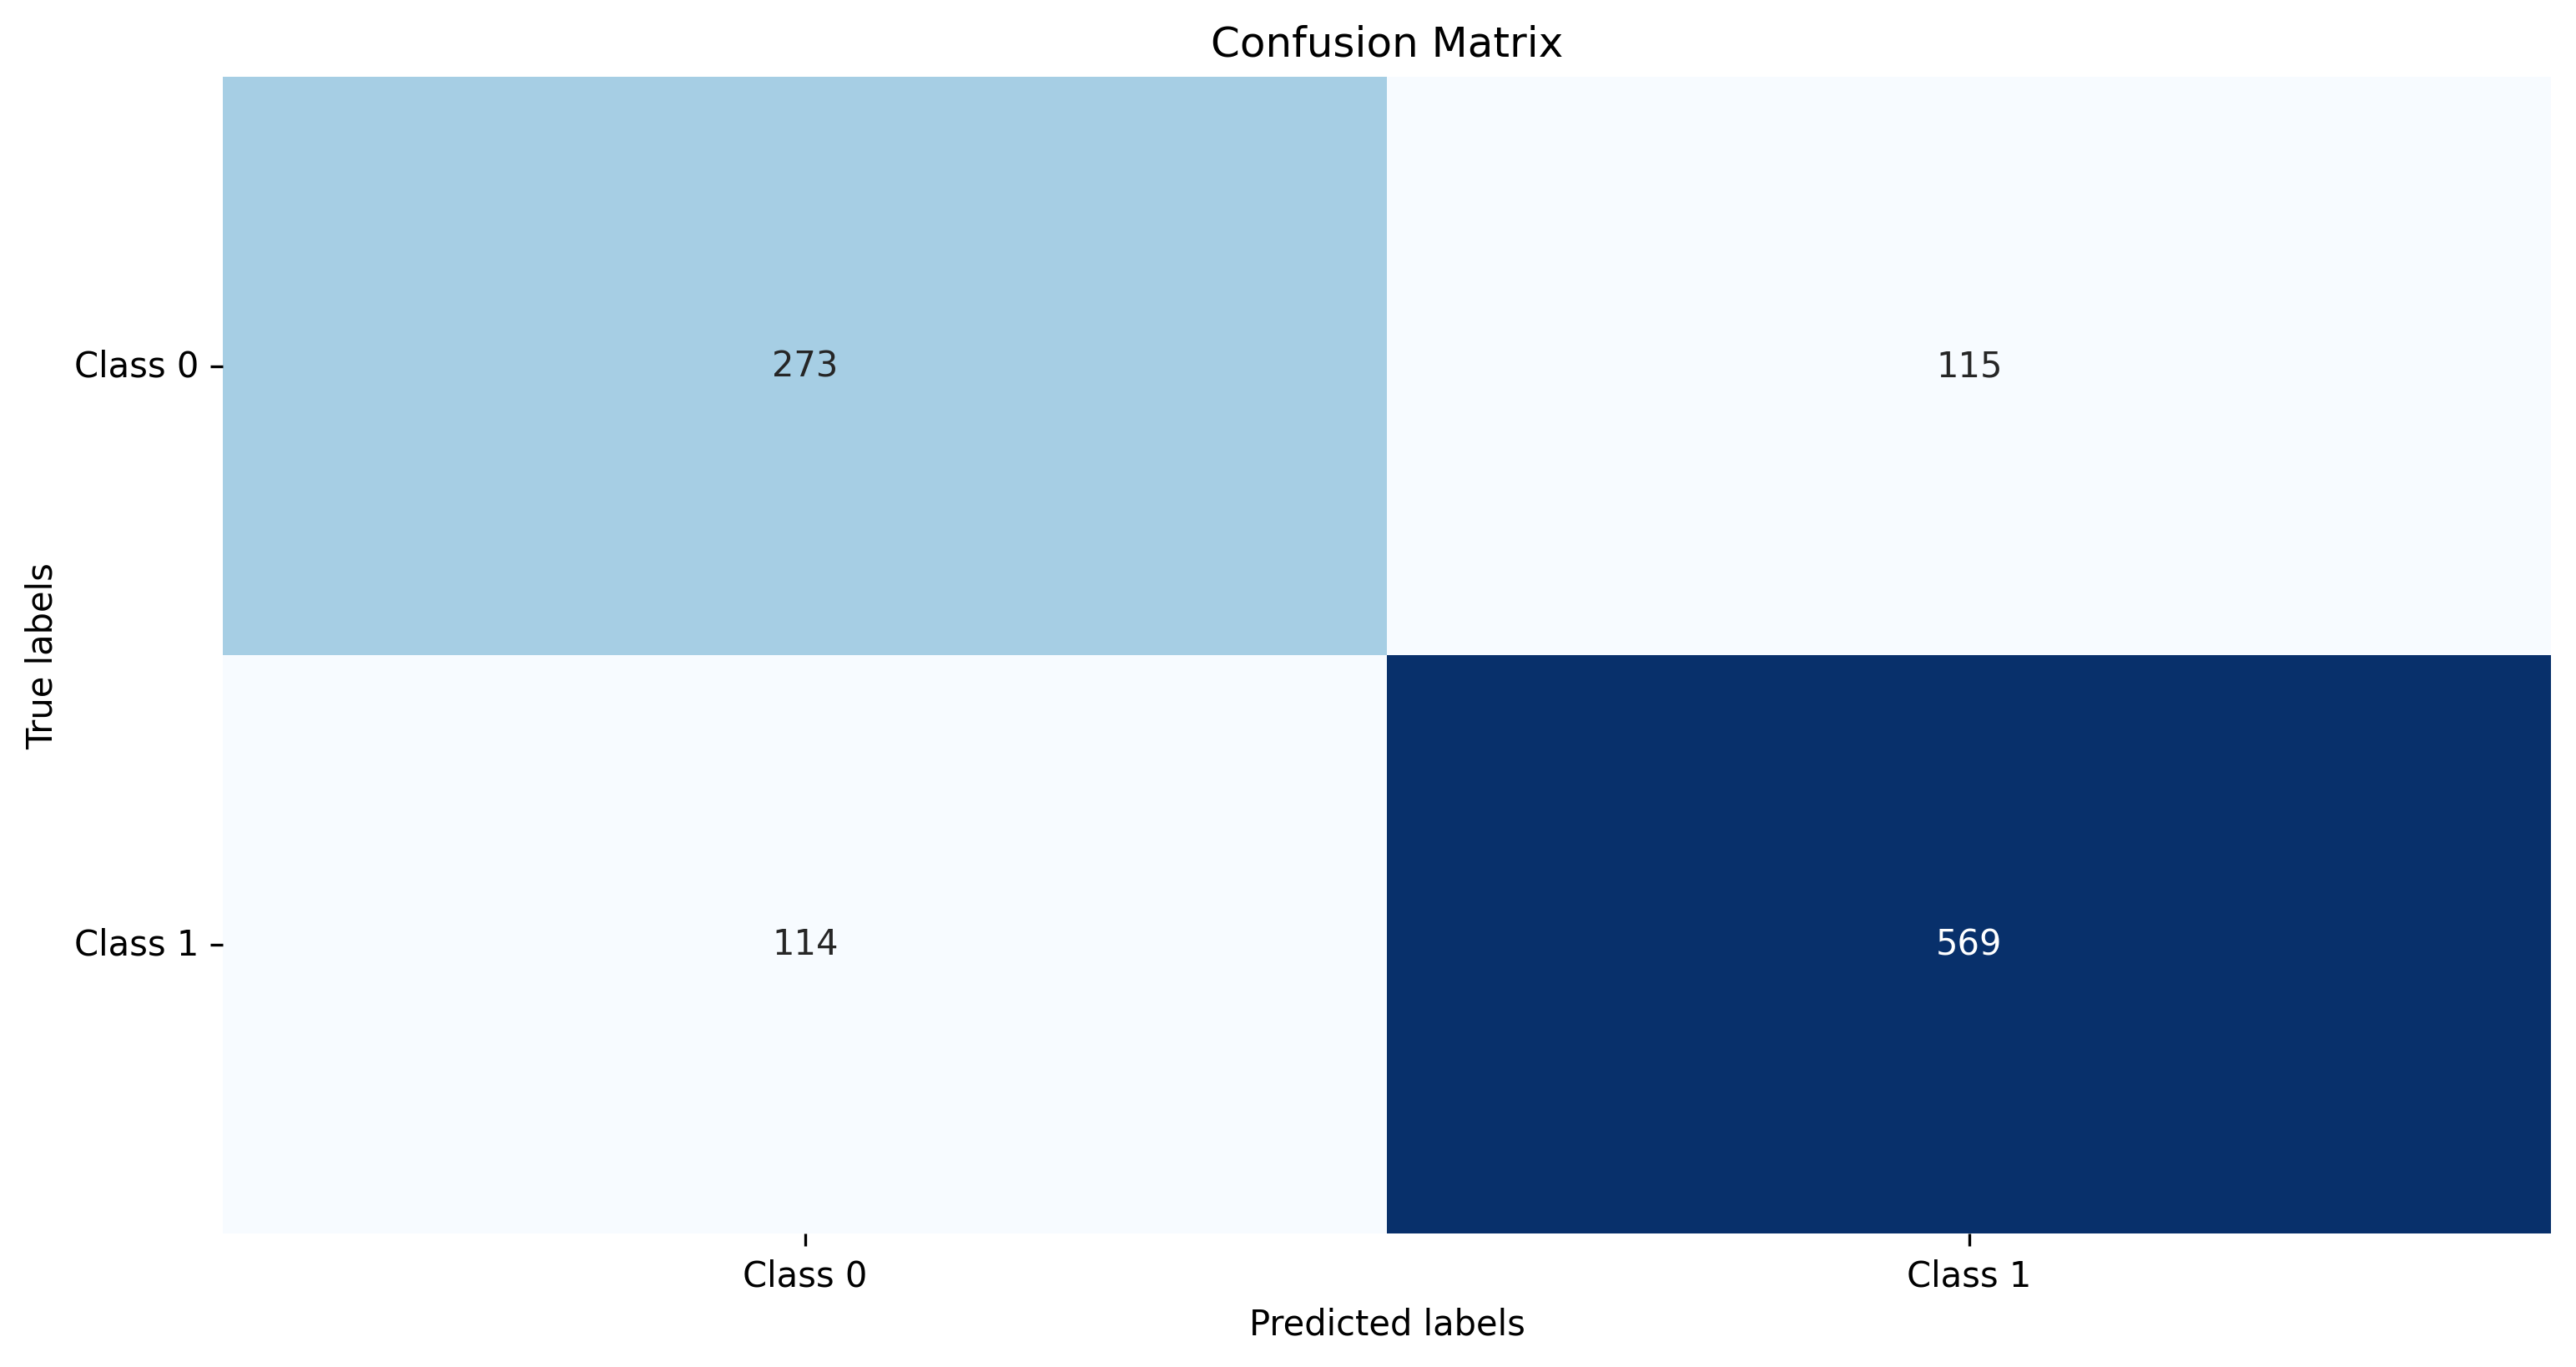

In [250]:
# Assuming y_test and y_pred are defined from your model's predictions
conf_matrix = confusion_matrix(y_test, y_pred)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(12, 6), dpi=300)  # Increase figure size for better readability
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)

# Add labels and title for clarity
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.xticks(ticks=[0.5, 1.5], labels=['Class 0', 'Class 1'])  # Adjust labels as needed
plt.yticks(ticks=[0.5, 1.5], labels=['Class 0', 'Class 1'], rotation=0)  # Adjust labels as needed

plt.show()

In [251]:
residuals = y_test - y_pred

3664    0
1773   -1
427     0
4527    0
1809    0
       ..
3144    0
5566    0
3710   -1
5005    0
682     0
Name: death, Length: 1071, dtype: int64

In [253]:
mse_from_residuals = np.mean(residuals**2)
mse_from_residuals

0.2138188608776844